In [2]:
from lightglue.utils import load_image, ImagePreprocessor
from lightglue.viz2d import plot_images
from hpatches import HPatchesDataset

%load_ext autoreload
%autoreload 2

In [7]:
ds = HPatchesDataset()
ds[0]

tensor([0.7500, 0.7500])
tensor([0.7500, 0.7500])


{'H_0to1': array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], dtype=float32),
 'scene': 'i_ajuntament',
 'image0': tensor([[[0.6192, 0.6624, 0.6692,  ..., 0.8454, 0.8203, 0.8093],
          [0.6497, 0.6804, 0.6882,  ..., 0.8402, 0.8118, 0.8144],
          [0.6644, 0.6853, 0.7024,  ..., 0.8322, 0.8033, 0.8032],
          ...,
          [0.3098, 0.3186, 0.3073,  ..., 0.3674, 0.3889, 0.3831],
          [0.3101, 0.3137, 0.3239,  ..., 0.3601, 0.3618, 0.3732],
          [0.3306, 0.3121, 0.3377,  ..., 0.3561, 0.3493, 0.3540]],
 
         [[0.6192, 0.6624, 0.6692,  ..., 0.8454, 0.8203, 0.8093],
          [0.6497, 0.6804, 0.6882,  ..., 0.8402, 0.8118, 0.8144],
          [0.6644, 0.6853, 0.7024,  ..., 0.8322, 0.8033, 0.8032],
          ...,
          [0.3098, 0.3186, 0.3073,  ..., 0.3674, 0.3889, 0.3831],
          [0.3101, 0.3137, 0.3239,  ..., 0.3601, 0.3618, 0.3732],
          [0.3306, 0.3121, 0.3377,  ..., 0.3561, 0.3493, 0.3540]],
 
         [[0.6192, 0.6624, 0.6692,  ..., 0.

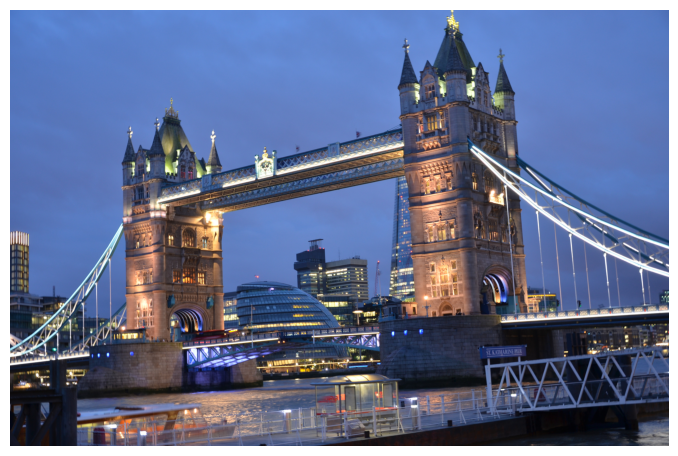

In [53]:

img = load_image("data/hpatches-sequences-release/i_londonbridge/4.ppm")
plot_images([img])


# LightGlue

In [25]:
from pathlib import Path
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

from lightglue import LightGlue, SuperPoint, DISK, SIFT, ALIKED, DoGHardNet
from lightglue.utils import load_image, rbd
from lightglue.viz2d import plot_images, plot_keypoints

### Load extractor and matcher module

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# SuperPoint + LightGlue
extractor = SuperPoint(max_num_keypoints=2048).eval().cuda()  # load the extractor
matcher = LightGlue(features='superpoint').eval().cuda()  # load the matcher

# or DISK + LightGlue, ALIKED + LightGlue or SIFT + LightGlue
#extractor = DISK(max_num_keypoints=2048).eval().cuda()  # load the extractor
#matcher = LightGlue(features='disk').eval().cuda()  # load the matcher

### Loading images

In [27]:
# load each image as a torch.Tensor on GPU with shape (3,H,W), normalized in [0,1]
images = Path("./datasets/megadepth_test_1500/Undistorted_SfM/0015/images")
image0 = load_image(images / '29307281_d7872975e2_o.jpg')
image1 = load_image(images / '50646217_c352086389_o.jpg')

### Feature extraction and matching

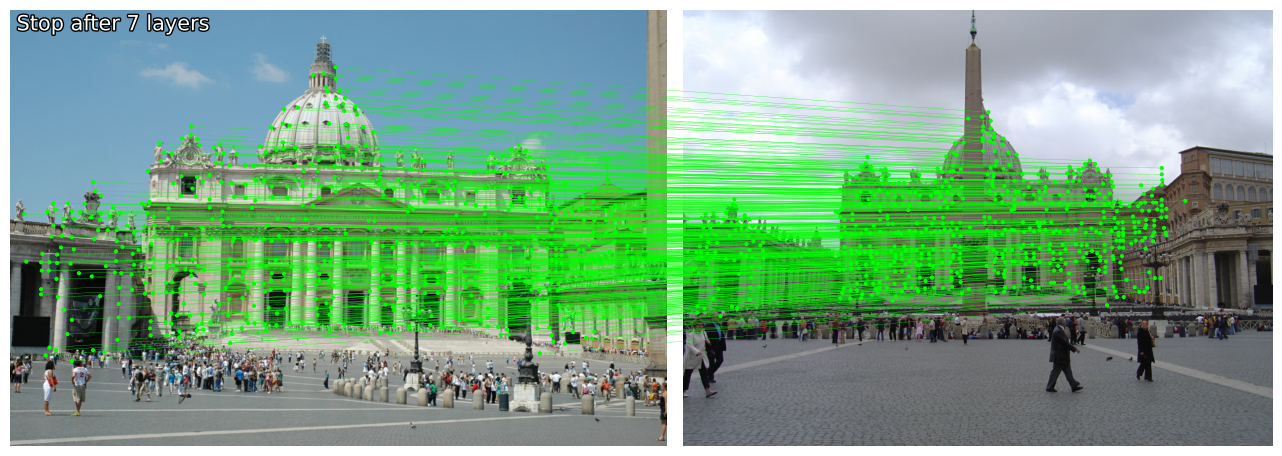

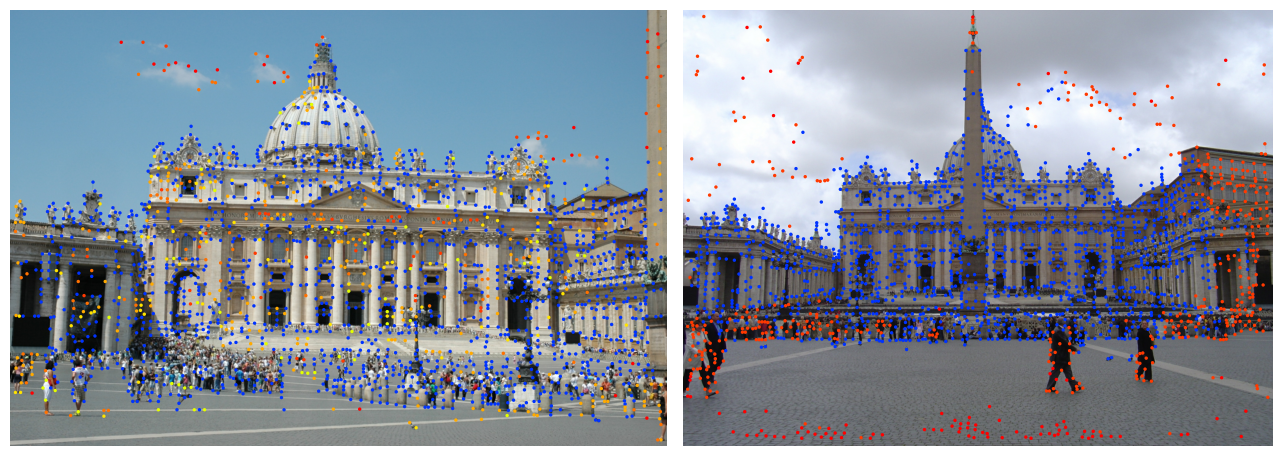

In [28]:
# extract local features
feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))

# match the features
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers')

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=6)

### Feature-Based Image Warping 

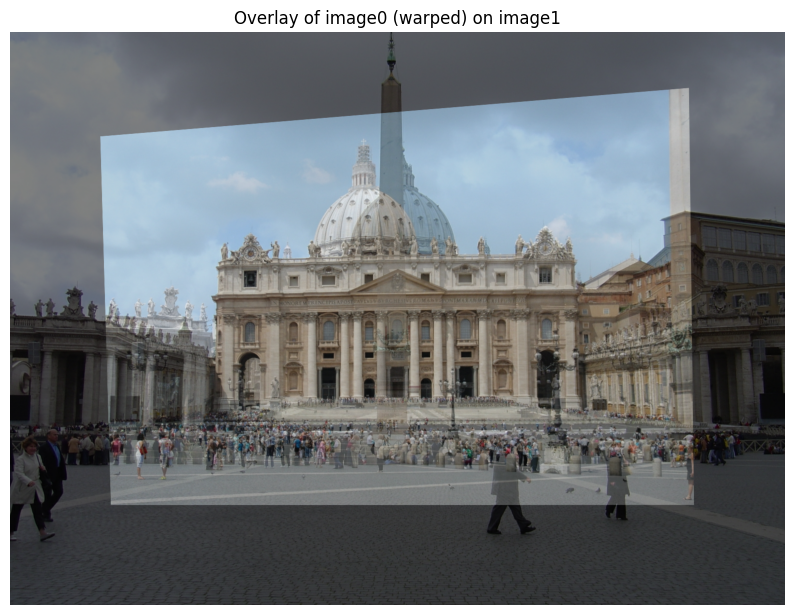

In [30]:
# convert keypoints and images if needed
m_kpts0_np = m_kpts0.cpu().numpy() if isinstance(m_kpts0, torch.Tensor) else m_kpts0
m_kpts1_np = m_kpts1.cpu().numpy() if isinstance(m_kpts1, torch.Tensor) else m_kpts1

# compute homography
H, inliers = cv2.findHomography(m_kpts0_np, m_kpts1_np, cv2.RANSAC, 3.0)
if H is None:
    raise RuntimeError("Homography not found: too few valid matches.")

# convert image0 and image1 to numpy arrays (H, W, 3)
img0_np = to_pil_image(image0.cpu()).convert("RGB")
img1_np = to_pil_image(image1.cpu()).convert("RGB")
img0_np = np.array(img0_np)
img1_np = np.array(img1_np)
H1, W1 = img1_np.shape[:2]

# apply the transformation
warped_img0 = cv2.warpPerspective(img0_np, H, (W1, H1))

# simple blending (pixel averaging)
blended = cv2.addWeighted(warped_img0, 0.5, img1_np, 0.5, 0)

# display the result
plt.figure(figsize=(10, 8))
plt.imshow(blended)
plt.title("Overlay of image0 (warped) on image1")
plt.axis("off")
plt.show()

## Relative pose estimation Experiment